# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


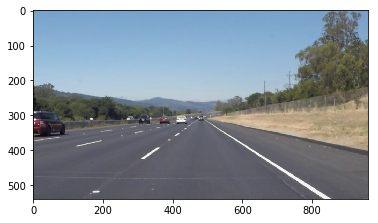

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [86]:
import math

prev_right_slopes = []
prev_left_slopes = []

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_slopes = []
    right_slopes = []
    left_centers = []
    right_centers = []
    left_lines = []
    right_lines = []
    left_xs = []
    left_ys = []
    right_ys = []
    right_xs = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            center = [(x2 + x1) / 2, (y2 + y1) / 2]

            # Left lane
            if slope < 0:
                left_slopes.append(slope)
                left_centers.append(center)
                left_lines.append(line)
                left_xs.extend([x1, x2])
                left_ys.extend([y1, y2])   
            # Right lane
            else:
                right_slopes.append(slope)
                right_centers.append(center)
                right_lines.append(line)
                right_xs.extend([x1, x2])
                right_ys.extend([y1, y2])                
                

    top_y = 325
    bottom_y = 540
    
    #process_line(img, color, right_slopes, right_centers, top_y, bottom_y, prev_right_slopes)
    #process_line(img, color, left_slopes, left_centers, top_y, bottom_y, prev_left_slopes)

    left_top_point, left_bottom_point = calculate_line(left_xs, left_ys, top_y, bottom_y, prev_left_slopes)
    right_top_point, right_bottom_point = calculate_line(right_xs, right_ys, top_y, bottom_y, prev_right_slopes)
    
    cv2.line(img, left_top_point, left_bottom_point, color, 10)
    cv2.line(img, right_top_point, right_bottom_point, color, 10)

def calculate_line(xs, ys, top_y, bottom_y, prev_slopes):
    m, b = np.polyfit(xs, ys, 1)
    print('{}: {}'.format('Prev slopes', prev_slopes))
    mean_m = np.mean(np.append(prev_slopes, m))
    if np.isnan(mean_m):
        mean_m = m
        
    if abs(mean_m - m) < 0.025:
        prev_slopes.append(m)
    else:
        mean_m = np.mean(prev_slopes)
        print('{}={}''Line discarded with m', m)
        
    top_x = int((top_y - b) / mean_m)
    bottom_x = int((bottom_y - b) / mean_m)
    return (top_x, top_y), (bottom_x, bottom_y)
    
def process_line(img, color, slopes, centers, top_y, bottom_y, prev_slopes):
    """
    Curate, calculate and show a new line from the set of lines defined by slopes and centers
    """
    curated_idx = curate_data_idx(slopes)
    curated_slopes = np.array(slopes)[curated_idx]
    curated_centers = np.array(centers)[curated_idx]
    slope = np.mean(curated_slopes, axis=0)
    center = np.mean(curated_centers, axis=0)
    
    if not np.isnan(slope) and not np.isnan(center).any():
        prev_slopes.append(slope)
        slope = np.mean(prev_slopes)
        top_point = calculate_new_point(top_y, slope, center)
        bottom_point = calculate_new_point(bottom_y, slope, center)

        cv2.line(img, top_point, bottom_point, color, 20)
    else:
        print('{}: {}'.format('Failing Slopes', slopes))
        print('{}: {}'.format('Failing Centers', centers))
        
def curate_data_idx(arr):
    """
    Return the indexes of the elements that are not outliers
    """
    elements = np.array(arr)

    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    cond = np.logical_and(arr > mean - 0.5 * sd, arr < mean + 0.5 * sd)
    return np.where(cond)
    
#     d = np.abs(elements - np.median(elements))
#     mdev = np.median(d)
#     s = d/mdev if mdev else 0.
#   #  print('{}: {}'.format('Cond', np.where(elements[s < 2.])))
#     result = elements[s < 0.5]
#     return np.where()
    

def calculate_new_point(y_coordinate, slope, point):
    return (int(point[0] + (y_coordinate - point[1]) / slope), y_coordinate)

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Processing image solidWhiteCurve.jpg
Prev slopes: []
Prev slopes: []
Processing image solidWhiteRight.jpg
Prev slopes: [-0.69155079713530399]
Prev slopes: [0.58808506492052981]
Processing image solidYellowCurve.jpg
Prev slopes: [-0.69155079713530399, -0.68382940994469876]
Prev slopes: [0.58808506492052981, 0.63450866518844473]
Processing image solidYellowCurve2.jpg
Prev slopes: [-0.69155079713530399, -0.68382940994469876, -0.7190866458734263]
Prev slopes: [0.58808506492052981, 0.63450866518844473, 0.58679070118029231]
Processing image solidYellowLeft.jpg
Prev slopes: [-0.69155079713530399, -0.68382940994469876, -0.7190866458734263, -0.72451311469001445]
Prev slopes: [0.58808506492052981, 0.63450866518844473, 0.58679070118029231, 0.60042815617248257]
Processing image whiteCarLaneSwitch.jpg
Prev slopes: [-0.69155079713530399, -0.68382940994469876, -0.7190866458734263, -0.72451311469001445, -0.70278728954539937]
Prev slopes: [0.58808506492052981, 0.63450866518844473, 0.58679070118029231, 

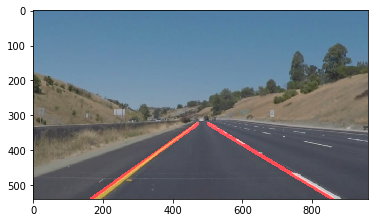

In [87]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Pipeline for a single image
def pipeline(img):
    """
    Chain of operations to process an image to find lane lines
    """
    # 1. Convert the image to grayscale
    gray_img = grayscale(img)
    
    result = gray_img
    
    # 2. Region masking
    img_shape = img.shape
    
    # Let's first try with a triangle as it seems to fit with the images provided.
    # We can later see if a isosceles trapezium fits better
    
    # TODO Vertices related to img_shape values
    vertices = np.array([[475, 300], [130, 540], [875, 540]], dtype=np.int32)
    # Note: fillPoly requires a list of points as an input
    result = region_of_interest(gray_img, [vertices])
    
    # 3. Suppress noise and spurious gradient by applying Gaussian smoothing
    gaussian_kernel_size = 5
    result = gaussian_blur(result, gaussian_kernel_size)
    
    # 4. Apply Canny Edge Detector
    canny_low_threshold = 50
    canny_high_threshold = 150
    result = canny(result, canny_low_threshold, canny_high_threshold)
    
    # 5. Apply Hough Transform
    rho = 2
    theta = np.pi/180 # angular resolution in radians of the Hough grid. 1 degree
    threshold = 15 # 15 points in image space need to be associated with each line segment
    min_line_length = 40 # In pixels
    max_line_gap = 20 # In pixels
    result = hough_lines(result, rho, theta, threshold, min_line_length, max_line_gap)
    
    return result

images_dir = "test_images"
images_output_dir = 'test_images_output'
images = os.listdir(images_dir)
prev_right_slopes = []
prev_left_slopes = []
for image_file in images:
    print('{} {}'.format('Processing image', image_file))
    image = mpimg.imread(os.path.join(images_dir, image_file))
    result = pipeline(image)
    cv2.imwrite(os.path.join(images_output_dir, image_file), result)
    result = weighted_img(result, image)
    plt.imshow(result)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    result = weighted_img(result, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [89]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
prev_right_slopes = []
prev_left_slopes = []
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Prev slopes: []
Prev slopes: []
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  3%|▎         | 6/222 [00:00<00:03, 57.37it/s]

Prev slopes: [-0.71048422813837853]
Prev slopes: [0.61135750670250255]
Prev slopes: [-0.71048422813837853, -0.71048422813837853]
Prev slopes: [0.61135750670250255, 0.61135750670250255]
Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442]
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621]
Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162]
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126]
Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937]
{}={}Line discarded with m -0.662490341117
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126, 0.60705250799177102]
Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937]
{}={}Line discarded with m -0.672345634868
Prev 

  9%|▉         | 21/222 [00:00<00:03, 62.18it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987]
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126, 0.60705250799177102, 0.62300816061024467, 0.61993943312414579, 0.61413301499544692, 0.60546395416825516, 0.61947412269087276, 0.61482252719870145, 0.62365164504773807, 0.59586919886561829, 0.62557715460449903]
Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737]
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126, 0.60705250799177102, 0.62300816061024467, 0.61993943312414579, 0.61413301499544692, 0.60546395416825516, 0.61947412269087276, 0.61482252719870145, 0.62365164504773807, 0.59586919886561829, 0.62

 16%|█▌        | 35/222 [00:00<00:02, 64.36it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105]
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126, 0.60705250799177102, 0.62300816061024467, 0.61993943312414579, 0.61413301499544692, 0.60546395416825516, 0.61947412269087276, 0.61482252719870145, 0.62365164504773807, 0.59586919886561829, 0.62557715460449903, 0.60598954708906894, 0.61401401493702767, 0.62527603680138844, 0.61155713384679677, 0.61255444430210626, 0.62583963117699359, 0.60923799755153374, 0.59929762958049759, 0.61507832726744782, 0.62137912896231151, 0.633073

 19%|█▉        | 42/222 [00:00<00:02, 65.35it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651]
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126, 0.60705250799177102, 0.62300816061024467, 0.61993943312414579, 0.61413301499544692, 0.60546395416825516, 0.619474122690872

 24%|██▍       | 54/222 [00:00<00:03, 48.04it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751]
Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.6240272351

 29%|██▉       | 64/222 [00:01<00:03, 45.70it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 34%|███▍      | 75/222 [00:01<00:03, 47.27it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 36%|███▋      | 81/222 [00:01<00:02, 47.50it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 42%|████▏     | 93/222 [00:01<00:02, 49.58it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 47%|████▋     | 104/222 [00:02<00:02, 46.62it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 52%|█████▏    | 115/222 [00:02<00:02, 46.61it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 56%|█████▋    | 125/222 [00:02<00:02, 46.85it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 59%|█████▉    | 131/222 [00:02<00:01, 48.47it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 61%|██████▏   | 136/222 [00:02<00:01, 46.11it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 64%|██████▎   | 141/222 [00:02<00:01, 46.25it/s]


Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126, 0.60705250799177102, 0.62300816061024467, 0.61993943312414579, 0.61413301499544692, 0.60546395416825516, 0.61947412269087276, 0.61482252719870145, 0.62365164504773807, 0.59586919886561829, 0.62557715460449903, 0.60598954708906894, 0.61401401493702767, 0.62527603680138844, 0.61155713384679677, 0.61255444430210626, 0.62583963117699359, 0.60923799755153374, 0.59929762958049759, 0.61507832726744782, 0.62137912896231151, 0.63307394522036797, 0.61141706374535498, 0.63215896309565633, 0.62141110777557951, 0.63358193407542884, 0.60668905369638848, 0.6151638027137537, 0.6207382558951573, 0.62562702148374671, 0.61444147749809408, 0.6235527452121632, 0.60461151338747343, 0.60527190844290935, 0.60030592240399638, 0.61947213516881405, 0.61854633497027889, 0.62784604729395466, 0.6238432630287517, 0.6263118328014069, 0.61426753764080233, 0.63970923333386209, 0.61428157733101307, 0.62053505765168648, 0.6

 66%|██████▌   | 146/222 [00:02<00:01, 45.04it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 68%|██████▊   | 151/222 [00:03<00:01, 44.84it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 73%|███████▎  | 162/222 [00:03<00:01, 47.21it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 78%|███████▊  | 173/222 [00:03<00:01, 46.92it/s]


Prev slopes: [0.61135750670250255, 0.61135750670250255, 0.62402723514532621, 0.61243235644501126, 0.60705250799177102, 0.62300816061024467, 0.61993943312414579, 0.61413301499544692, 0.60546395416825516, 0.61947412269087276, 0.61482252719870145, 0.62365164504773807, 0.59586919886561829, 0.62557715460449903, 0.60598954708906894, 0.61401401493702767, 0.62527603680138844, 0.61155713384679677, 0.61255444430210626, 0.62583963117699359, 0.60923799755153374, 0.59929762958049759, 0.61507832726744782, 0.62137912896231151, 0.63307394522036797, 0.61141706374535498, 0.63215896309565633, 0.62141110777557951, 0.63358193407542884, 0.60668905369638848, 0.6151638027137537, 0.6207382558951573, 0.62562702148374671, 0.61444147749809408, 0.6235527452121632, 0.60461151338747343, 0.60527190844290935, 0.60030592240399638, 0.61947213516881405, 0.61854633497027889, 0.62784604729395466, 0.6238432630287517, 0.6263118328014069, 0.61426753764080233, 0.63970923333386209, 0.61428157733101307, 0.62053505765168648, 0.6

 80%|████████  | 178/222 [00:03<00:00, 47.79it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 82%|████████▏ | 183/222 [00:03<00:00, 47.07it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 85%|████████▌ | 189/222 [00:03<00:00, 48.65it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 88%|████████▊ | 195/222 [00:03<00:00, 47.49it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 90%|█████████ | 200/222 [00:04<00:00, 46.41it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 92%|█████████▏| 205/222 [00:04<00:00, 44.83it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 95%|█████████▌| 211/222 [00:04<00:00, 46.65it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

 98%|█████████▊| 217/222 [00:04<00:00, 48.25it/s]

Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

100%|█████████▉| 221/222 [00:04<00:00, 49.12it/s]


Prev slopes: [-0.71048422813837853, -0.71048422813837853, -0.72589892073552442, -0.69813194679132162, -0.70546265735455937, -0.68544401132868427, -0.69045057847275271, -0.71149835842888987, -0.7021963469521737, -0.70562357669376075, -0.69295127180113547, -0.68298368298368306, -0.68563595456509507, -0.67979890376023477, -0.67789269803912866, -0.67771540457381996, -0.67343368611522103, -0.69054876077636074, -0.69555615954338501, -0.7082290015954793, -0.70662207995734105, -0.69488445675764465, -0.67908288066883404, -0.67419884156218779, -0.68670646143477798, -0.68230960885012815, -0.68634788705986383, -0.67936987801985183, -0.69558943169649357, -0.69074367261884229, -0.68857016718069952, -0.7071991417407304, -0.7029851667015764, -0.70364377464607986, -0.67900623902021651, -0.68218353589581704, -0.6793559240936915, -0.6789278941379745, -0.67552590984078764, -0.69546932700735897, -0.68943981900666829, -0.69669054101540751, -0.7026601774459269, -0.71456536230586243, -0.70950133314766839, -0.

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [90]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [73]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
prev_right_slopes = float('nan')
prev_left_slopes = float('nan')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Prev slopes: -0.6645905765283939
Prev slopes: 0.6069243457587218
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 7/682 [00:00<00:10, 65.85it/s]

Prev slopes: -0.6645905765283939
Prev slopes: 0.6069243457587218
Prev slopes: -0.6708991399530884
Prev slopes: 0.6366013102585981
Prev slopes: -0.667780153919212
Prev slopes: 0.6345485556027205
Prev slopes: -0.6714576075529268
Prev slopes: 0.6629928697066317
Prev slopes: -0.6725963633465392
Prev slopes: 0.6127661966402209
Prev slopes: -0.6720415049038279
Prev slopes: 0.5926280986942145
Prev slopes: -0.6648266680052188
Prev slopes: 0.5953543464428634
Prev slopes: -0.6728611075958155
Prev slopes: 0.5918565068236766
Prev slopes: -0.6786580708021503
Prev slopes: 0.5953013475497917
Prev slopes: -0.6846889805697302
Prev slopes: 0.5980987163650036
Prev slopes: -0.6761680343882719
Prev slopes: 0.601423766584817
Prev slopes: -0.6844014175747316
Prev slopes: 0.5921075405296256
Prev slopes: -0.6993885369087962
Prev slopes: 0.6055343598227068
Prev slopes: -0.6788219396895239
Prev slopes: 0.6170145103445841


  3%|▎         | 22/682 [00:00<00:09, 66.31it/s]

Prev slopes: -0.6843125996917614
Prev slopes: 0.6250653751855446
Prev slopes: -0.6984455301277639
Prev slopes: 0.6295443713527262
Prev slopes: -0.7004724225350815
Prev slopes: 0.2401340234070589
Prev slopes: -0.6981558180121403
Prev slopes: 0.5955449859393243
Prev slopes: -0.6846283643317733
Prev slopes: 0.5935276454330519
Prev slopes: -0.6937396872972874
Prev slopes: 0.594565157309187
Prev slopes: -0.7083251063030411
Prev slopes: 0.5907633469353579
Prev slopes: -0.7059910933260171
Prev slopes: 0.5973917487466845
Prev slopes: -0.7033950916843309
Prev slopes: 0.5906168326562659
Prev slopes: -0.6901355100803978
Prev slopes: 0.5931461735105129
Prev slopes: -0.705356644531823
Prev slopes: 0.5972653725572828
Prev slopes: -0.6990239268591815
Prev slopes: 0.5995764687772742
Prev slopes: -0.6954261623982063
Prev slopes: 0.6154044556211119
Prev slopes: -0.7025626068709204
Prev slopes: 0.6102026962132528


  5%|▌         | 36/682 [00:00<00:09, 65.68it/s]

Prev slopes: -0.7009301794482166
Prev slopes: 0.6180184748462727
Prev slopes: -0.7085559467302555
Prev slopes: 0.6088319956071683
Prev slopes: -0.7188788539231683
Prev slopes: 0.05836642978721644
Prev slopes: -0.7015574486918589
Prev slopes: 0.5993086116617558
Prev slopes: -0.7093304918911512
Prev slopes: 0.6011163258412926
Prev slopes: -0.7196176986756287
Prev slopes: 0.5985036448199493
Prev slopes: -0.7165971186208582
Prev slopes: 0.6010757778132887
Prev slopes: -0.7191889938883443
Prev slopes: 0.5984356946049241
Prev slopes: -0.7225312296016823
Prev slopes: 0.5938194905159077
Prev slopes: -0.7140409615341169
Prev slopes: 0.6015562800522396
Prev slopes: -0.7211606563547841
Prev slopes: 0.605871359313127
Prev slopes: -0.7170842946507152
Prev slopes: 0.6085496268093586
Prev slopes: -0.7182922603044906
Prev slopes: 0.26843395724526903
Prev slopes: -0.704912712210295
Prev slopes: 0.1444193580053009


  6%|▋         | 44/682 [00:00<00:09, 67.58it/s]

Prev slopes: -0.7231979088228486
Prev slopes: 0.5996899790279927
Prev slopes: -0.7193030798426151
Prev slopes: 0.5995804116578392
Prev slopes: -0.7157393654720738
Prev slopes: 0.5981307559040757
Prev slopes: -0.7211728136165589
Prev slopes: 0.5926434248464438
Prev slopes: -0.7144468798868783
Prev slopes: 0.60378610659836
Prev slopes: -0.7215742246590934
Prev slopes: 0.605313087077149
Prev slopes: -0.7111425532766412
Prev slopes: 0.5903775994252237


  8%|▊         | 57/682 [00:00<00:12, 48.94it/s]

Prev slopes: -0.7142687217134276
Prev slopes: 0.5917438945381819
Prev slopes: -0.7188480178106287
Prev slopes: 0.605777581128508
Prev slopes: -0.7123294098939491
Prev slopes: 0.6102836896008523
Prev slopes: -0.7226664215911525
Prev slopes: 0.6086101977613405
Prev slopes: -0.7145984700507527
Prev slopes: 0.6062330400262886
Prev slopes: -0.7176656175157704
Prev slopes: 0.6060317611143876
Prev slopes: -0.7104879599323468
Prev slopes: 0.02068228471793382
Prev slopes: -0.7012341083606016
Prev slopes: 0.5996130319183562
Prev slopes: -0.6941337716427098
Prev slopes: 0.593610490260981
Prev slopes: -0.7046027145777761
Prev slopes: 0.5958876495344777


 10%|▉         | 68/682 [00:01<00:12, 49.70it/s]

Prev slopes: -0.6998746749692796
Prev slopes: 0.5896318702535723
Prev slopes: -0.7063563827217468
Prev slopes: 0.5832671549163212
Prev slopes: -0.6932424569186704
Prev slopes: 0.5945496030360179
Prev slopes: -0.7164206233710592
Prev slopes: 0.6044467378981943
Prev slopes: -0.7107112912588122
Prev slopes: 0.6087900753055135
Prev slopes: -0.7013960036050754
Prev slopes: 0.6206864433727063
Prev slopes: -0.7067989953973342
Prev slopes: 0.6071336834604832
Prev slopes: -0.7066683894889889
Prev slopes: 0.6166450133627215
Prev slopes: -0.7008094337281531
Prev slopes: 0.5921329135942747
Prev slopes: -0.7053767063022506
Prev slopes: 0.06457822380718804


 12%|█▏        | 80/682 [00:01<00:11, 51.83it/s]

Prev slopes: -0.6921879363184245
Prev slopes: 0.5941895726548266
Prev slopes: -0.6996216426337643
Prev slopes: 0.5884689555141667
Prev slopes: -0.6983320080458129
Prev slopes: 0.593641794956313
Prev slopes: -0.6917941001343192
Prev slopes: 0.5940755137248049
Prev slopes: -0.7037739070039074
Prev slopes: 0.5959938935686037
Prev slopes: -0.7044334958707195
Prev slopes: 0.6002634879700812
Prev slopes: -0.6990614798462853
Prev slopes: 0.6005787889353973
Prev slopes: -0.7119214176030411
Prev slopes: 0.62037266304943
Prev slopes: -0.6983771519773347
Prev slopes: 0.6113542646027713
Prev slopes: -0.703634324270167
Prev slopes: 0.6303425075780525
Prev slopes: -0.7021986147369058
Prev slopes: 0.25649264417416046


 13%|█▎        | 86/682 [00:01<00:12, 49.20it/s]

Prev slopes: -0.7139163415694099
Prev slopes: 0.04935377648081239
Prev slopes: -0.7009666597053649
Prev slopes: 0.5893035388906709
Prev slopes: -0.710497498419137
Prev slopes: 0.5890612743175084
Prev slopes: -0.700822745881311
Prev slopes: 0.5953475636381343
Prev slopes: -0.7270919596254043
Prev slopes: 0.5984194491437927
Prev slopes: -0.7039512868702639
Prev slopes: 0.5923396355968799
Prev slopes: -0.7041151477147986
Prev slopes: 0.5887626498020742
Prev slopes: -0.709348483458043
Prev slopes: 0.5983166516891968
Prev slopes: -0.7035280833676371
Prev slopes: 0.6056402579529668
Prev slopes: -0.6932100301875704
Prev slopes: 0.6110052944782468


 14%|█▍        | 98/682 [00:01<00:11, 50.30it/s]

Prev slopes: -0.6895657823266915
Prev slopes: 0.6141822280549976
Prev slopes: -0.7006919460475792
Prev slopes: 0.6137041965777751
Prev slopes: -0.6869172566830789
Prev slopes: 0.14045961269641336
Prev slopes: -0.7021458069785247
Prev slopes: 0.5905256298165931
Prev slopes: -0.6997914910728034
Prev slopes: 0.5850831843703875
Prev slopes: -0.6984329714099083
Prev slopes: 0.583099008716686
Prev slopes: -0.6878585229211631
Prev slopes: 0.5815635699451663
Prev slopes: -0.7004208376420624
Prev slopes: 0.6025383765377352
Prev slopes: -0.6916795691833316
Prev slopes: 0.5993779215156095
Prev slopes: -0.6947998294429335
Prev slopes: 0.5925284640889218
Prev slopes: -0.7008686951654747

 16%|█▌        | 109/682 [00:02<00:11, 49.61it/s]


Prev slopes: 0.6056444230246611
Prev slopes: -0.6881390083825729
Prev slopes: 0.6176522928178882
Prev slopes: -0.6853316926091976
Prev slopes: 0.6151062567453949
Prev slopes: -0.6812936050180534
Prev slopes: 0.6165957327562263
Prev slopes: -0.7068632729910046
Prev slopes: 0.6353834787638382
Prev slopes: -0.6972762403336704
Prev slopes: 0.6250509759749476
Prev slopes: -0.7014488179388085
Prev slopes: 0.5825205920388354
Prev slopes: -0.7051672773704287
Prev slopes: 0.5854275694833266
Prev slopes: -0.6953429193444688
Prev slopes: 0.5861465537174448
Prev slopes: -0.6905576990586775
Prev slopes: 0.5877475000886538

 18%|█▊        | 120/682 [00:02<00:11, 49.93it/s]


Prev slopes: -0.6995519582194699
Prev slopes: 0.6115739215348739
Prev slopes: -0.6920126536641142
Prev slopes: 0.6118085892027888
Prev slopes: -0.6863072674122275
Prev slopes: 0.6021329424983133
Prev slopes: -0.6861064557078195
Prev slopes: 0.6072010990792267
Prev slopes: -0.6838105960701397
Prev slopes: 0.6290037136626779
Prev slopes: -0.6921974585879563
Prev slopes: 0.620702239582994
Prev slopes: -0.6943519692596218
Prev slopes: 0.6301415225518754
Prev slopes: -0.7054742709158044
Prev slopes: 0.6222402308565955
Prev slopes: -0.6927527352904886
Prev slopes: 0.5901760830561722
Prev slopes: -0.6875106883552858
Prev slopes: 0.5889633944671852


 19%|█▉        | 132/682 [00:02<00:10, 52.18it/s]

Prev slopes: -0.6957563164552308
Prev slopes: 0.5930258284541984
Prev slopes: -0.6977763062077532
Prev slopes: 0.5969992579669734
Prev slopes: -0.6899710031951984
Prev slopes: 0.6078537993434678
Prev slopes: -0.7032710982752061
Prev slopes: 0.5993992572934602
Prev slopes: -0.7021156799966842
Prev slopes: 0.5965930847997268
Prev slopes: -0.6810971490614898
Prev slopes: 0.6111948643026507
Prev slopes: -0.6932691674129271
Prev slopes: 0.3453563379293938
Prev slopes: -0.6897314639162363
Prev slopes: 0.6270414672519941
Prev slopes: -0.6979993166234623
Prev slopes: 0.6097966037186706
Prev slopes: -0.6956962156827096
Prev slopes: 0.2908401096776599
Prev slopes: -0.6964430976486514
Prev slopes: 0.09467581069507626
Prev slopes: -0.7035380302452391
Prev slopes: 0.5992309835261246


 20%|██        | 138/682 [00:02<00:10, 51.72it/s]

Prev slopes: -0.6814101471645069
Prev slopes: 0.5866703866605395
Prev slopes: -0.6749020717631306
Prev slopes: 0.5897121835590912
Prev slopes: -0.6996364559118797
Prev slopes: 0.5884106483534132
Prev slopes: -0.6873413929226004
Prev slopes: 0.5878278120454692
Prev slopes: -0.685893527069591
Prev slopes: 0.6022407800619212
Prev slopes: -0.6997112364758565
Prev slopes: 0.5945058200546378
Prev slopes: -0.7117771615179674
Prev slopes: 0.5987716337983556
Prev slopes: -0.6908025215885739
Prev slopes: 0.6216357506918694
Prev slopes: -0.6864763176118357
Prev slopes: 0.6096650933332695
Prev slopes: -0.6862586734864393
Prev slopes: 0.30724876215727254
Prev slopes: -0.683404559840744
Prev slopes: 0.6185502248337869


 22%|██▏       | 150/682 [00:02<00:10, 52.32it/s]

Prev slopes: -0.6994081192915488
Prev slopes: 0.5915276425635196
Prev slopes: -0.6971753043408376
Prev slopes: 0.5859697106833628
Prev slopes: -0.68897193438784
Prev slopes: 0.584826088104354
Prev slopes: -0.6743130225229207
Prev slopes: 0.5981724907467887
Prev slopes: -0.692934885661193
Prev slopes: 0.5971456303487065
Prev slopes: -0.6861717350774406
Prev slopes: 0.58449659916721
Prev slopes: -0.6878820902718915
Prev slopes: 0.5886630830781614
Prev slopes: -0.6843721847879702
Prev slopes: 0.5911960038266999
Prev slopes: -0.6825642529299568
Prev slopes: 0.5998849996330338
Prev slopes: -0.677226740780057
Prev slopes: 0.6092711603040288
Prev slopes: -0.6959881409641384
Prev slopes: 0.6055367791100682
Prev slopes: -0.6948835608541766
Prev slopes: 0.18785246174177675


 24%|██▍       | 162/682 [00:03<00:09, 53.66it/s]

Prev slopes: -0.6747559575372251
Prev slopes: 0.6162206167108822
Prev slopes: -0.7002746598942514
Prev slopes: 0.5834859276045566
Prev slopes: -0.7044086916059157
Prev slopes: 0.5689042089697167
Prev slopes: -0.693696003163465
Prev slopes: 0.5714855226610644
Prev slopes: -0.6813111199499194
Prev slopes: 0.5857524874968019
Prev slopes: -0.6678479825698446
Prev slopes: 0.5828917562146465
Prev slopes: -0.6789310221581374
Prev slopes: 0.5735766922391998
Prev slopes: -0.6979977955210538
Prev slopes: 0.5863735253238256
Prev slopes: -0.707022936948406
Prev slopes: 0.588904801505393
Prev slopes: -0.7053476910677792
Prev slopes: 0.5908857067280839
Prev slopes: -0.6778790698235211
Prev slopes: 0.6051451259069917
Prev slopes: -0.7059440892103882
Prev slopes: 0.5916523378083461
Prev slopes: -0.716094232360888

 26%|██▌       | 174/682 [00:03<00:09, 52.86it/s]


Prev slopes: 0.5932481838860629
Prev slopes: -0.7089142661149729
Prev slopes: -0.02559375687384612
Prev slopes: -0.6784910421624168
Prev slopes: 0.5825257199685103
Prev slopes: -0.7071349365665491
Prev slopes: 0.5838346461773655
Prev slopes: -0.6710744663400346
Prev slopes: 0.581257590075676
Prev slopes: -0.6965535408952102
Prev slopes: 0.5785394589638907
Prev slopes: -0.7137701821682679
Prev slopes: 0.5766040230076289
Prev slopes: -0.7331113433397863
Prev slopes: 0.5895313408284726
Prev slopes: -0.7174190089280306
Prev slopes: 0.5878023218240276
Prev slopes: -0.7083903100645931
Prev slopes: 0.578248298832936
Prev slopes: -0.71783743757845
Prev slopes: 0.5892362239695117


 27%|██▋       | 186/682 [00:03<00:10, 48.48it/s]

Prev slopes: -0.7221056409142792
Prev slopes: 0.5806881948615594
Prev slopes: -0.725252142336968
Prev slopes: 0.581739635826234
Prev slopes: -0.713974519770282
Prev slopes: 0.582309289440807
Prev slopes: -0.7076215581248299
Prev slopes: 0.575617602857145
Prev slopes: -0.7123006935661135
Prev slopes: 0.5813394599565368
Prev slopes: -0.7376715539830161
Prev slopes: 0.5830881375331666
Prev slopes: -0.741542448068399
Prev slopes: 0.5753452954169593
Prev slopes: -0.7324490829013952
Prev slopes: 0.5657231649276654
Prev slopes: -0.7239457567586187
Prev slopes: 0.5901519759118835


 29%|██▉       | 197/682 [00:03<00:09, 49.09it/s]

Prev slopes: -0.7484719373225919
Prev slopes: 0.5698703685190314
Prev slopes: -0.7434024652966679
Prev slopes: 0.5747266189534329
Prev slopes: -0.7167855215550492
Prev slopes: 0.5818155869560613
Prev slopes: -0.732282224642554
Prev slopes: 0.5796807869590543
Prev slopes: -0.7449709982180972
Prev slopes: 0.5819943544521459
Prev slopes: -0.7295805944899056
Prev slopes: 0.5718055857400021
Prev slopes: -0.7503625455020404
Prev slopes: 0.5798957328978683
Prev slopes: -0.7352288171267057
Prev slopes: 0.5719069896436354
Prev slopes: -0.7319908000842118
Prev slopes: 0.5669479147971027
Prev slopes: -0.7145319108476684
Prev slopes: 0.5792479362686798


 30%|██▉       | 202/682 [00:03<00:10, 44.97it/s]

Prev slopes: -0.7453765985764014
Prev slopes: 0.5721626616322546
Prev slopes: -0.7302751174567882
Prev slopes: 0.5624082953273678
Prev slopes: -0.7219030188149644
Prev slopes: 0.5734151806660854
Prev slopes: -0.7403436286134107
Prev slopes: 0.5718302265888712
Prev slopes: -0.7421779332552778
Prev slopes: 0.5762535815836117
Prev slopes: -0.7363792443851417
Prev slopes: 0.5834549548008472
Prev slopes: -0.7425526541998976
Prev slopes: 0.5879918018391194
Prev slopes: -0.7298940725226554
Prev slopes: 0.5782601731320779
Prev slopes: -0.7135540444088876
Prev slopes: 0.5720181640920469


 31%|███       | 212/682 [00:04<00:10, 44.22it/s]

Prev slopes: -0.7235300542814935
Prev slopes: 0.5689684999549874
Prev slopes: -0.7185884706560258
Prev slopes: 0.5668209226140002
Prev slopes: -0.6918440967207331
Prev slopes: 0.5713755664552839
Prev slopes: -0.724413604300567
Prev slopes: 0.5668191414808573
Prev slopes: -0.7214681280986378
Prev slopes: 0.5699631733866737
Prev slopes: -0.7041046391829551
Prev slopes: 0.5655393968300874
Prev slopes: -0.6971900945065129
Prev slopes: 0.5737987686706888
Prev slopes: -0.6799094401853844
Prev slopes: 0.5693319784488691
Prev slopes: -0.7043864664435734
Prev slopes: 0.5793283620821366


 33%|███▎      | 222/682 [00:04<00:10, 44.93it/s]

Prev slopes: -0.7103629091246931
Prev slopes: 0.5895138855375659
Prev slopes: -0.705534356395646
Prev slopes: 0.5897786259688569
Prev slopes: -0.7065698510302701
Prev slopes: 0.5943597717757791
Prev slopes: -0.7125500688315606
Prev slopes: 0.5698282821052625
Prev slopes: -0.7212738309951573
Prev slopes: 0.5678003811061523
Prev slopes: -0.6976966122455833
Prev slopes: 0.5821977738945953
Prev slopes: -0.6984739454185223
Prev slopes: 0.5779563649664708
Prev slopes: -0.7021253660672553
Prev slopes: 0.5760256479839256
Prev slopes: -0.7050637940775689
Prev slopes: 0.5795479702844312
Prev slopes: -0.6988540285209945
Prev slopes: 0.5816667789637227


 34%|███▍      | 232/682 [00:04<00:10, 43.93it/s]

Prev slopes: -0.7162767169917658
Prev slopes: 0.5856094672487554
Prev slopes: -0.7106566646406368
Prev slopes: 0.5944233976427603
Prev slopes: -0.696660964588533
Prev slopes: 0.591492475320248
Prev slopes: -0.7071069633883704
Prev slopes: 0.6071307456455564
Prev slopes: -0.7051554258965638
Prev slopes: 0.5902222724199769
Prev slopes: -0.7039389631851827
Prev slopes: 0.5852813115359962
Prev slopes: -0.7025189046604999
Prev slopes: 0.5803498159480431
Prev slopes: -0.6890985768338233
Prev slopes: 0.5759228505666752
Prev slopes: -0.6912203458201972
Prev slopes: 0.579014059002623
Prev slopes: -0.692445807248802
Prev slopes: 0.5736525496501568


 35%|███▌      | 242/682 [00:04<00:09, 44.50it/s]

Prev slopes: -0.6904207076363564
Prev slopes: 0.575278671525946
Prev slopes: -0.7010982986567232
Prev slopes: 0.5806180228236003
Prev slopes: -0.7008470856027967
Prev slopes: 0.5843297518122327
Prev slopes: -0.6903302153128055
Prev slopes: 0.5950739266018775
Prev slopes: -0.7060384062912403
Prev slopes: 0.5980686828817522
Prev slopes: -0.7083198950619487
Prev slopes: 0.6045874606186821
Prev slopes: -0.7037001857305891
Prev slopes: 0.5948436883214047
Prev slopes: -0.7040653141391451
Prev slopes: 0.27673822428798195
Prev slopes: -0.6962192122160822
Prev slopes: -0.005911418970714003
Prev slopes: -0.6894922820643326
Prev slopes: 0.578385806610531


 37%|███▋      | 253/682 [00:05<00:09, 43.84it/s]

Prev slopes: -0.691032595070978
Prev slopes: 0.5725129410300359
Prev slopes: -0.6769307332411273
Prev slopes: 0.5780527027160347
Prev slopes: -0.6920369150465719
Prev slopes: 0.5693063941437068
Prev slopes: -0.6965951832752967
Prev slopes: 0.5720837260495805
Prev slopes: -0.69463772920813
Prev slopes: 0.5832559066187274
Prev slopes: -0.6903560035279278
Prev slopes: 0.5882532549669907
Prev slopes: -0.6972724191265912
Prev slopes: 0.5784483297127152
Prev slopes: -0.713473195655718
Prev slopes: 0.5986036768043944
Prev slopes: -0.7050159765766008
Prev slopes: 0.5992133658670409


 38%|███▊      | 259/682 [00:05<00:09, 45.87it/s]

Prev slopes: -0.7110901222630277
Prev slopes: 0.5929247887338509
Prev slopes: -0.7099503932244405
Prev slopes: 0.5966060082800694
Prev slopes: -0.7005870173442501
Prev slopes: 0.5886374360418661
Prev slopes: -0.7218755964902366
Prev slopes: 0.5681930659913794
Prev slopes: -0.6931602167437488
Prev slopes: 0.5684272860041486
Prev slopes: -0.6962761675011825
Prev slopes: 0.572147589290458
Prev slopes: -0.7103076124549355
Prev slopes: 0.5710936167663014
Prev slopes: -0.7040379587376439
Prev slopes: 0.5800788512636641
Prev slopes: -0.710349992008306
Prev slopes: 0.5652170314427623
Prev slopes: -0.6926406834859481
Prev slopes: 0.574560672202129
Prev slopes: -0.707981851664836
Prev slopes: 0.5798973561767099


 40%|███▉      | 270/682 [00:05<00:09, 43.85it/s]

Prev slopes: -0.6963759659874492
Prev slopes: 0.5915566161331515
Prev slopes: -0.6975027960274643
Prev slopes: 0.5903388659986694
Prev slopes: -0.6980069408917033
Prev slopes: 0.15539385069845682
Prev slopes: -0.703204623871284
Prev slopes: 0.5935316821098042
Prev slopes: -0.6951793901823997
Prev slopes: 0.57618976506859
Prev slopes: -0.6836588131336329
Prev slopes: 0.579524886877828
Prev slopes: -0.6957003694375403
Prev slopes: 0.571867778326723
Prev slopes: -0.7139222353456355
Prev slopes: 0.5763065867256462
Prev slopes: -0.7075472980235707
Prev slopes: 0.5656235610933925


 41%|████      | 280/682 [00:05<00:09, 43.65it/s]

Prev slopes: -0.7051314410027143
Prev slopes: 0.566020376163883
Prev slopes: -0.7179176779050654
Prev slopes: 0.5729120296330493
Prev slopes: -0.7073038272813104
Prev slopes: 0.576666111966528
Prev slopes: -0.6996617562610398
Prev slopes: 0.5914161779858296
Prev slopes: -0.7073043892676183
Prev slopes: 0.5824477388442517
Prev slopes: -0.7089775476321828
Prev slopes: 0.5901276390187713
Prev slopes: -0.6979229886344415
Prev slopes: 0.5819373805923698
Prev slopes: -0.6967841144575692
Prev slopes: 0.09499150827188807
Prev slopes: -0.7097256462632956
Prev slopes: 0.407318815401157


 43%|████▎     | 290/682 [00:05<00:09, 41.94it/s]

Prev slopes: -0.6977783729233497
Prev slopes: 0.3599665803177424
Prev slopes: -0.7106478739044932
Prev slopes: 0.2100706369844021
Prev slopes: -0.7063984083557316
Prev slopes: 0.39246203534522633
Prev slopes: -0.7090716976666261
Prev slopes: 0.5729171039819503
Prev slopes: -0.7175102057677694
Prev slopes: 0.24866204453893032
Prev slopes: -0.7022789266501366
Prev slopes: 0.222464758414329
Prev slopes: -0.6992760401077519
Prev slopes: 0.2399718210020195
Prev slopes: -0.7131313344311264
Prev slopes: 0.19514421148014566


 43%|████▎     | 295/682 [00:06<00:09, 39.26it/s]

Prev slopes: -0.7064853930728909
Prev slopes: 0.11507622411719662
Prev slopes: -0.7048527042211495
Prev slopes: 0.5790228518503332
Prev slopes: -0.7200554335400975
Prev slopes: 0.600448634222326
Prev slopes: -0.7147238983639097
Prev slopes: 0.5733803291506437
Prev slopes: -0.6970318365711531
Prev slopes: 0.5805540088303943
Prev slopes: -0.7205571732400329
Prev slopes: 0.575091054174271
Prev slopes: -0.7199992527856923
Prev slopes: 0.5786812938249268
Prev slopes: -0.7157877956075199
Prev slopes: 0.5779311682959635
Prev slopes: -0.7214029305541129
Prev slopes: 0.5857652091117367
Prev slopes: -0.720281556198077
Prev slopes: 0.5780477884950972


 46%|████▌     | 311/682 [00:06<00:08, 44.31it/s]

Prev slopes: -0.7060187430221151
Prev slopes: 0.5891170427055913
Prev slopes: -0.7123531549929122
Prev slopes: 0.6036984874215153
Prev slopes: -0.7196532529222975
Prev slopes: 0.6002099716714504
Prev slopes: -0.7221805394870658
Prev slopes: 0.6070536662896339
Prev slopes: -0.7190371950855714
Prev slopes: 0.6090921821860238
Prev slopes: -0.7154451803174374
Prev slopes: 0.5787226330768661
Prev slopes: -0.7069537889266198
Prev slopes: 0.5802818548325596
Prev slopes: -0.70604286351853
Prev slopes: 0.5802402457994731
Prev slopes: -0.729630959832329
Prev slopes: 0.5826583343273493
Prev slopes: -0.7141176835400058
Prev slopes: 0.58125786419859


 46%|████▋     | 316/682 [00:06<00:08, 42.84it/s]

Prev slopes: -0.7324630596277185
Prev slopes: 0.5876253965544221
Prev slopes: -0.7015269848777269
Prev slopes: 0.5814788184477832
Prev slopes: -0.6935554891270828
Prev slopes: 0.5905838947229864
Prev slopes: -0.6896407454903111
Prev slopes: 0.6051807041354857
Prev slopes: -0.706823354341737
Prev slopes: 0.5894620007595233
Prev slopes: -0.7054790088317572
Prev slopes: 0.5935050190366296
Prev slopes: -0.7066684519147708
Prev slopes: 0.6048181957506732
Prev slopes: -0.6950087302437065
Prev slopes: 0.5785207174449477
Prev slopes: -0.7053078384357859
Prev slopes: 0.569824843468711


 48%|████▊     | 326/682 [00:06<00:08, 42.56it/s]

Prev slopes: -0.7250275111043613
Prev slopes: 0.5818300234671407
Prev slopes: -0.6953589478203999
Prev slopes: 0.5763634122368656
Prev slopes: -0.7033314730514805
Prev slopes: 0.5797746758531656
Prev slopes: -0.7092679798329109
Prev slopes: 0.5773567055842427
Prev slopes: -0.6927106536064276
Prev slopes: 0.5833635272530798
Prev slopes: -0.7013318101085484
Prev slopes: 0.5881734508452894
Prev slopes: -0.7060345521992585
Prev slopes: 0.5839605192140694
Prev slopes: -0.7138037886912223
Prev slopes: 0.592074801281509
Prev slopes: -0.6898841240339801
Prev slopes: 0.3124724776309802


 49%|████▉     | 336/682 [00:06<00:07, 44.33it/s]

Prev slopes: -0.7044839250979552
Prev slopes: 0.33659354223586346
Prev slopes: -0.7072227953707456
Prev slopes: -0.23622436436391758
Prev slopes: -0.7148137394371362
Prev slopes: 0.5758877470013589
Prev slopes: -0.7018417850445362
Prev slopes: 0.5694456794160955
Prev slopes: -0.6811797450684677
Prev slopes: 0.5717317401667944
Prev slopes: -0.6820173046418767
Prev slopes: 0.5773428259495598
Prev slopes: -0.6905381490664759
Prev slopes: 0.5745220954444958
Prev slopes: -0.6907015167491777
Prev slopes: 0.5722725868542368
Prev slopes: -0.6933397761035789
Prev slopes: 0.5894746278416132


 51%|█████     | 346/682 [00:07<00:07, 42.07it/s]

Prev slopes: -0.6975498167913466
Prev slopes: 0.608639898778932
Prev slopes: -0.6906347586179011
Prev slopes: 0.3974525644249157
Prev slopes: -0.6855770319973559
Prev slopes: 0.6124635774184484
Prev slopes: -0.6947344308777464
Prev slopes: 0.6009522522174282
Prev slopes: -0.6939619087696423
Prev slopes: 0.05614899623011007
Prev slopes: -0.7040563639735361
Prev slopes: 0.5692199933899416
Prev slopes: -0.678759857881503
Prev slopes: 0.5739047907516784
Prev slopes: -0.6895005496802875
Prev slopes: 0.5655430103343462
Prev slopes: -0.6892275621905876
Prev slopes: 0.5715340141972863


 52%|█████▏    | 356/682 [00:07<00:07, 43.03it/s]

Prev slopes: -0.6767518659063791
Prev slopes: 0.5737763711188616
Prev slopes: -0.6772041265240327
Prev slopes: 0.5879432763500186
Prev slopes: -0.704528531561807
Prev slopes: 0.4129581845885221
Prev slopes: -0.684898842133095
Prev slopes: 0.5887771074660925
Prev slopes: -0.7016351461529554
Prev slopes: 0.5981667460356335
Prev slopes: -0.6932226329885015
Prev slopes: 0.5970478790547908
Prev slopes: -0.69008956225762
Prev slopes: 0.604378362219223
Prev slopes: -0.6941311839193148
Prev slopes: 0.5974435480613554
Prev slopes: -0.6971741578760915
Prev slopes: 0.14725942986172846


 53%|█████▎    | 361/682 [00:07<00:07, 43.70it/s]

Prev slopes: -0.6924165626304988
Prev slopes: 0.5659946609319975
Prev slopes: -0.6909857839556157
Prev slopes: 0.5646974904468759
Prev slopes: -0.6982110610956727
Prev slopes: 0.5849682905139892
Prev slopes: -0.6954721655823942
Prev slopes: 0.5802449434200195
Prev slopes: -0.6942366939708497
Prev slopes: 0.5778044135447994
Prev slopes: -0.7004787012705699
Prev slopes: 0.579165574304723
Prev slopes: -0.7140046922914868
Prev slopes: 0.5968842337083536
Prev slopes: -0.6992796310106465
Prev slopes: 0.6068122398941095
Prev slopes: -0.7163462159679992
Prev slopes: 0.6034457434921248


 55%|█████▍    | 372/682 [00:07<00:07, 44.22it/s]

Prev slopes: -0.6900686724341132
Prev slopes: 0.6104307536877955
Prev slopes: -0.7061320372828699
Prev slopes: 0.6055385448244858
Prev slopes: -0.6942182200106751
Prev slopes: 0.07312477062038078
Prev slopes: -0.7092549714788643
Prev slopes: 0.5654251944222748
Prev slopes: -0.7113277139843363
Prev slopes: 0.5652136638377041
Prev slopes: -0.7126275009230705
Prev slopes: 0.5684504177891379
Prev slopes: -0.7095912206688363
Prev slopes: 0.5707065977334779
Prev slopes: -0.7131313143202187
Prev slopes: 0.5831859509042687
Prev slopes: -0.7276342204115754
Prev slopes: 0.5837720508699371
Prev slopes: -0.7408199066246388
Prev slopes: 0.5788627190355133


 56%|█████▌    | 382/682 [00:07<00:06, 44.76it/s]

Prev slopes: -0.6962764796934249
Prev slopes: 0.5943451169609315
Prev slopes: -0.6944262645752891
Prev slopes: 0.3756098638590471
Prev slopes: -0.7062770676741221
Prev slopes: 0.5951419667481319
Prev slopes: -0.7065278990711139
Prev slopes: 0.30183920514967444
Prev slopes: -0.7088699744719036
Prev slopes: 0.5793879817288864
Prev slopes: -0.7000188971170095
Prev slopes: 0.5675205505639459
Prev slopes: -0.694701520186915
Prev slopes: 0.5641649972408846
Prev slopes: -0.6955126041619679
Prev slopes: 0.5711789759396606
Prev slopes: -0.7057007558838989
Prev slopes: 0.5811156010642908
Prev slopes: -0.6981916002386697
Prev slopes: 0.5763117871673552


 57%|█████▋    | 392/682 [00:08<00:06, 46.43it/s]

Prev slopes: -0.7070297892673955
Prev slopes: 0.5841572032027196
Prev slopes: -0.7033239463332281
Prev slopes: 0.5791298692482707
Prev slopes: -0.7021596571338841
Prev slopes: 0.6062912576976062
Prev slopes: -0.6952714049987535
Prev slopes: 0.6010187686150358
Prev slopes: -0.6928674974544404
Prev slopes: 0.5998030820366589
Prev slopes: -0.6779618828260237
Prev slopes: 0.607266487558747
Prev slopes: -0.7043708201149975
Prev slopes: 0.058313164387526414
Prev slopes: -0.683831562041578
Prev slopes: 0.571856785496255
Prev slopes: -0.7005094383702685
Prev slopes: 0.575702400929985
Prev slopes: -0.6942109817049987
Prev slopes: 0.5745132493027176


 59%|█████▉    | 402/682 [00:08<00:06, 45.26it/s]

Prev slopes: -0.7032607213617834
Prev slopes: 0.5840128745460662
Prev slopes: -0.7046818538972637
Prev slopes: 0.5823487182796395
Prev slopes: -0.6933392616390822
Prev slopes: 0.5905976057087197
Prev slopes: -0.7038332133575981
Prev slopes: 0.5988050919478481
Prev slopes: -0.7000475938529046
Prev slopes: 0.61350856971804
Prev slopes: -0.6930135378964957
Prev slopes: 0.6174659203676944
Prev slopes: -0.6933126024007757
Prev slopes: 0.6031676155604009
Prev slopes: -0.6812678436530619
Prev slopes: 0.6046920163013234
Prev slopes: -0.6987506484323011
Prev slopes: 0.5751769011793412
Prev slopes: -0.696949484876521
Prev slopes: 0.5716039445295931


 61%|██████    | 413/682 [00:08<00:05, 48.63it/s]

Prev slopes: -0.696035603594892
Prev slopes: 0.5727050403887484
Prev slopes: -0.6945960090531815
Prev slopes: 0.5689775245543188
Prev slopes: -0.6993467525905877
Prev slopes: 0.571896051846167
Prev slopes: -0.6857154843499386
Prev slopes: 0.58589024247041
Prev slopes: -0.6920642181111787
Prev slopes: 0.5856206232018535
Prev slopes: -0.6920711402786595
Prev slopes: 0.5946156624345402
Prev slopes: -0.672314251303275
Prev slopes: 0.5917000412476949
Prev slopes: -0.6855248123345721
Prev slopes: 0.6105949855620999
Prev slopes: -0.6923435831970921
Prev slopes: 0.6188543701121658
Prev slopes: -0.6913485051768221
Prev slopes: 0.6185256093372753
Prev slopes: -0.6829253324231257
Prev slopes: 0.6297628493510067


 62%|██████▏   | 424/682 [00:08<00:05, 49.97it/s]

Prev slopes: -0.691911355321581
Prev slopes: 0.5795180546428668
Prev slopes: -0.6978099117201214
Prev slopes: 0.5779283163297599
Prev slopes: -0.69444851421999
Prev slopes: 0.5786012536477778
Prev slopes: -0.6823997138289315
Prev slopes: 0.5795484761686254
Prev slopes: -0.155895246468143
Prev slopes: 0.5942936381449713
Prev slopes: -0.7006325465367768
Prev slopes: 0.5996203340594329
Prev slopes: -0.6880464738295435
Prev slopes: 0.5977907051198442
Prev slopes: -0.6894009077155832
Prev slopes: 0.6072982366980971
Prev slopes: -0.6802774395478307
Prev slopes: 0.6242119037455384
Prev slopes: -0.6943891476064208
Prev slopes: 0.37291357261841446
Prev slopes: -0.6808809908025839
Prev slopes: 0.6197185212084472


 64%|██████▍   | 435/682 [00:09<00:05, 47.93it/s]

Prev slopes: -0.6841134366180242
Prev slopes: 0.6087316362885621
Prev slopes: -0.6733911446994105
Prev slopes: 0.582130975813866
Prev slopes: -0.681096448457014
Prev slopes: 0.5778922207815765
Prev slopes: -0.6946732774902747
Prev slopes: 0.5882146392785231
Prev slopes: -0.6857394290956648
Prev slopes: 0.5873727394713844
Prev slopes: -0.6919268318225716
Prev slopes: 0.584032396250023
Prev slopes: -0.68916478248766
Prev slopes: 0.5856435398607395
Prev slopes: -0.6752426348712646
Prev slopes: 0.5899313367435944
Prev slopes: -0.6846635743710386
Prev slopes: 0.5968226386772459
Prev slopes: -0.6919546832087443
Prev slopes: 0.6109142624589713


 66%|██████▌   | 447/682 [00:09<00:04, 49.73it/s]

Prev slopes: -0.6948941259795863
Prev slopes: 0.6120276196938177
Prev slopes: -0.6945292569681273
Prev slopes: 0.33839024312729016
Prev slopes: -0.6869473525951896
Prev slopes: 0.6259820228062782
Prev slopes: -0.6873933456734331
Prev slopes: 0.5813278386000302
Prev slopes: -0.6872658974593416
Prev slopes: 0.5797816241184698
Prev slopes: -0.7011286029202916
Prev slopes: 0.5836071949380043
Prev slopes: -0.6952300976056376
Prev slopes: 0.58304481186252
Prev slopes: -0.7019374857251094
Prev slopes: 0.5811667568044699
Prev slopes: -0.6885104247677178
Prev slopes: 0.603196418988091
Prev slopes: -0.6950839326718617
Prev slopes: 0.585359646345045


 66%|██████▋   | 453/682 [00:09<00:04, 50.17it/s]

Prev slopes: -0.6891463880739571
Prev slopes: 0.6049601901182072
Prev slopes: -0.6974800187419787
Prev slopes: 0.6060839428180893
Prev slopes: -0.6909969818959548
Prev slopes: 0.6045095481182192
Prev slopes: -0.6992418439654774
Prev slopes: 0.6308373403825229
Prev slopes: -0.6967731680356286
Prev slopes: 0.6076434803175422
Prev slopes: -0.6863781508416323
Prev slopes: 0.6075487801502564
Prev slopes: -0.6959375146419764
Prev slopes: 0.593623793945114
Prev slopes: -0.6942288562437172
Prev slopes: 0.5812962444177119
Prev slopes: -0.6827928591131547
Prev slopes: 0.5866865001473023
Prev slopes: -0.6863296990336967
Prev slopes: 0.5819475553199822
Prev slopes: -0.20372597317553856
Prev slopes: 0.5901672825594506


 68%|██████▊   | 465/682 [00:09<00:04, 49.57it/s]

Prev slopes: -0.6836048792540933
Prev slopes: 0.5839636280626995
Prev slopes: -0.6770236987184066
Prev slopes: 0.5878769595882175
Prev slopes: -0.6934166514579438
Prev slopes: 0.598491666925297
Prev slopes: -0.685921825380049
Prev slopes: 0.5924136947117727
Prev slopes: -0.6899856344517549
Prev slopes: 0.6113220926511709
Prev slopes: -0.6893906620880303
Prev slopes: 0.6084256235496145
Prev slopes: -0.6883031472696151
Prev slopes: 0.6188655656347375
Prev slopes: -0.6918725042019306
Prev slopes: 0.6044550161922065
Prev slopes: -0.6903409586114052
Prev slopes: 0.5810158321874992
Prev slopes: -0.6946495101234132
Prev slopes: 0.5841226437701255
Prev slopes: -0.6854127160288843
Prev slopes: 0.5784135777203381


 70%|██████▉   | 477/682 [00:09<00:04, 50.75it/s]

Prev slopes: -0.6861632550218965
Prev slopes: 0.5929802109410988
Prev slopes: -0.6790103880446701
Prev slopes: 0.5983321241653218
Prev slopes: -0.6924841241982314
Prev slopes: 0.6034257543198933
Prev slopes: -0.684418117807099
Prev slopes: 0.5936549838546209
Prev slopes: -0.6896958785670387
Prev slopes: 0.6005807264998223
Prev slopes: -0.6884661132919473
Prev slopes: 0.6063540053919407
Prev slopes: -0.6938125200634931
Prev slopes: 0.3074292844462815
Prev slopes: -0.6774597882788286
Prev slopes: 0.30377450699111896
Prev slopes: -0.682068106038559
Prev slopes: 0.6089861414664455
Prev slopes: -0.6866726730466134
Prev slopes: 0.5770757927718654
Prev slopes: -0.6787832477893464
Prev slopes: 0.5825436795875503


 72%|███████▏  | 489/682 [00:10<00:03, 52.78it/s]

Prev slopes: -0.6909424248641546
Prev slopes: 0.5764700203657669
Prev slopes: -0.6779724586578845
Prev slopes: 0.5797418408602707
Prev slopes: -0.6730028959751456
Prev slopes: 0.5924908196359325
Prev slopes: -0.6809445790562919
Prev slopes: 0.5943305018552351
Prev slopes: -0.7012770935492654
Prev slopes: 0.5914129750157463
Prev slopes: -0.6950584861012499
Prev slopes: 0.604050709042273
Prev slopes: -0.6893523441286139
Prev slopes: 0.6041256226217195
Prev slopes: -0.7036444605199822
Prev slopes: 0.6353229120113767
Prev slopes: -0.6867401716914943
Prev slopes: 0.29034169797916604
Prev slopes: -0.6889921868790512
Prev slopes: 0.21932013244774173
Prev slopes: -0.6999894662142678
Prev slopes: 0.5886328426647758


 73%|███████▎  | 501/682 [00:10<00:03, 51.15it/s]

Prev slopes: -0.6790529594172958
Prev slopes: 0.5784454945773086
Prev slopes: -0.6920725965402333
Prev slopes: 0.5803582076757346
Prev slopes: -0.6931119614363586
Prev slopes: 0.587671010264661
Prev slopes: -0.6841682703341024
Prev slopes: 0.5886965344240817
Prev slopes: -0.6756876245293898
Prev slopes: 0.5889210618645013
Prev slopes: -0.6828961692822911
Prev slopes: 0.6064614053673962
Prev slopes: -0.6864393625262256
Prev slopes: 0.6000464625190404
Prev slopes: -0.6876943706108667
Prev slopes: 0.6035351093855668
Prev slopes: -0.6878888617600757
Prev slopes: 0.6070603710671623
Prev slopes: -0.6925277536492604
Prev slopes: 0.6085575237322839


 74%|███████▍  | 507/682 [00:10<00:03, 51.09it/s]

Prev slopes: -0.6907155639317433
Prev slopes: 0.2347554709356996
Prev slopes: -0.6907156124136077
Prev slopes: 0.5861943871924049
Prev slopes: -0.6974351601146683
Prev slopes: 0.5847588573928979
Prev slopes: -0.6909163963960031
Prev slopes: 0.5788041336423174
Prev slopes: -0.6913789871515359
Prev slopes: 0.5871166925787104
Prev slopes: -0.6868191025117286
Prev slopes: 0.5945784117810518
Prev slopes: -0.6944931226560173
Prev slopes: 0.5800053541582758
Prev slopes: -0.6884008469531906
Prev slopes: 0.5858624238270453
Prev slopes: -0.6853447754148558
Prev slopes: 0.5891324534205041
Prev slopes: -0.680327387674585
Prev slopes: 0.5922584074783748
Prev slopes: -0.2210309368437671
Prev slopes: 0.5975652180145609


 76%|███████▌  | 519/682 [00:10<00:03, 50.99it/s]

Prev slopes: -0.6849483707258249
Prev slopes: 0.616843465984794
Prev slopes: -0.6940263006831631
Prev slopes: 0.6081277232263848
Prev slopes: -0.6834879114054127
Prev slopes: 0.6102663500676646
Prev slopes: -0.6895196181823102
Prev slopes: 0.5782363335803458
Prev slopes: -0.6929720104648415
Prev slopes: 0.5871014558483376
Prev slopes: -0.6994864971347965
Prev slopes: 0.5794067247820672
Prev slopes: -0.682903389823743
Prev slopes: 0.5868813519704477
Prev slopes: -0.678173245409834
Prev slopes: 0.5978746220526874
Prev slopes: -0.6739753266613463
Prev slopes: 0.6145098878763279
Prev slopes: -0.6892562462089927
Prev slopes: 0.5870815701566189
Prev slopes: -0.6829375014326964
Prev slopes: 0.601023074939092
Prev slopes: -0.6842766608943898

 78%|███████▊  | 531/682 [00:10<00:02, 53.29it/s]


Prev slopes: 0.5991271196836871
Prev slopes: -0.6802031259492403
Prev slopes: 0.627925014257894
Prev slopes: -0.6851500147193513
Prev slopes: 0.6213371334533005
Prev slopes: -0.6901310013099382
Prev slopes: 0.6176008527756408
Prev slopes: -0.6838219740457636
Prev slopes: 0.5825019354168504
Prev slopes: -0.6654748628506947
Prev slopes: 0.5891842212038737
Prev slopes: -0.6755068628738545
Prev slopes: 0.5909773451042044
Prev slopes: -0.6921262409963226
Prev slopes: 0.6014046937259588
Prev slopes: -0.673206877048915
Prev slopes: 0.6013635080346462
Prev slopes: -0.670609265891557
Prev slopes: 0.6030283176062335
Prev slopes: -0.6774572911624032
Prev slopes: 0.6145192154858334


 80%|███████▉  | 543/682 [00:11<00:02, 50.45it/s]

Prev slopes: -0.6722533937291097
Prev slopes: 0.6071998785086943
Prev slopes: -0.6761315962594635
Prev slopes: 0.6080667527322673
Prev slopes: -0.6731738809264316
Prev slopes: 0.6186179335136912
Prev slopes: -0.6844321634732164
Prev slopes: 0.6125854714894874
Prev slopes: -0.6895127451260239
Prev slopes: 0.6184046071749355
Prev slopes: -0.6833139092801975
Prev slopes: 0.5857536535271265
Prev slopes: -0.6844049557129769
Prev slopes: 0.58659045672889
Prev slopes: -0.6714880196599653
Prev slopes: 0.5873635419877047
Prev slopes: -0.6800480349534876
Prev slopes: 0.5921426674404651
Prev slopes: -0.6921008779396842
Prev slopes: 0.6039779483847996


 82%|████████▏ | 556/682 [00:11<00:02, 56.11it/s]

Prev slopes: -0.6970819204300883
Prev slopes: 0.5939160109851641
Prev slopes: -0.694516598536181
Prev slopes: 0.5937609844549152
Prev slopes: -0.700238442986241
Prev slopes: 0.593689824866793
Prev slopes: -0.6980541644500137
Prev slopes: 0.616045470913463
Prev slopes: -0.6920889620881842
Prev slopes: 0.6174574610250718
Prev slopes: -0.7012690533969436
Prev slopes: 0.6169022217464168
Prev slopes: -0.6880014827170778
Prev slopes: 0.2717276864472298
Prev slopes: -0.7084567253879954
Prev slopes: 0.6183793682964551
Prev slopes: -0.6947017044774261
Prev slopes: 0.5963817567906798
Prev slopes: -0.685530438084937
Prev slopes: 0.5960638387775979
Prev slopes: -0.6865730069124594
Prev slopes: 0.5995010853070224
Prev slopes: -0.6934601734100639
Prev slopes: 0.5972811620179245
Prev slopes: -0.6992190951264298
Prev slopes: 0.6048430560241469


 83%|████████▎ | 568/682 [00:11<00:02, 52.68it/s]

Prev slopes: -0.7007322763505728
Prev slopes: 0.5999069732650545
Prev slopes: -0.6988287023903031
Prev slopes: 0.5981206824957228
Prev slopes: -0.6965660366331703
Prev slopes: 0.5994977119715786
Prev slopes: -0.6972794148733767
Prev slopes: 0.5976737871025138
Prev slopes: -0.6940619486632593
Prev slopes: 0.6064719999482496
Prev slopes: -0.6902155157196265
Prev slopes: 0.6214223176704157
Prev slopes: -0.6964977767668513
Prev slopes: 0.6029384778541721
Prev slopes: -0.7138188661658277
Prev slopes: 0.5970631500390403
Prev slopes: -0.6888192761451614
Prev slopes: 0.5915506789547854
Prev slopes: -0.7130818116804513
Prev slopes: 0.5935366853599091
Prev slopes: -0.7236418263581436
Prev slopes: 0.6054436187215539
Prev slopes: -0.698664090727611
Prev slopes: 0.6018340950087533

 84%|████████▍ | 574/682 [00:11<00:02, 52.26it/s]


Prev slopes: -0.6899982837040839
Prev slopes: 0.6073951499531393
Prev slopes: -0.6990139875421658
Prev slopes: 0.595041813666241
Prev slopes: -0.7117347868224116
Prev slopes: 0.5965440517736137
Prev slopes: -0.7124433557850196
Prev slopes: 0.6025916492701203
Prev slopes: -0.719833172184567
Prev slopes: 0.6025376198839149
Prev slopes: -0.7304443551956082
Prev slopes: 0.5975851419295671
Prev slopes: -0.7261821367426067
Prev slopes: 0.6056477547891168
Prev slopes: -0.7104648529802212
Prev slopes: 0.5976732294085237
Prev slopes: -0.7242192430394716
Prev slopes: 0.5897049255279866
Prev slopes: -0.7300097591831413
Prev slopes: 0.5957126489844669


 86%|████████▌ | 586/682 [00:12<00:02, 47.90it/s]

Prev slopes: -0.731957519904152
Prev slopes: 0.5945493293689809
Prev slopes: -0.738245158823986
Prev slopes: 0.5913292170157961
Prev slopes: -0.7074309640404514
Prev slopes: 0.5934736002482082
Prev slopes: -0.7092883566552819
Prev slopes: 0.5936390680031254
Prev slopes: -0.7429815002514112
Prev slopes: 0.5954182606871655
Prev slopes: -0.7327574886515424
Prev slopes: 0.5985399137294066
Prev slopes: -0.7044815675141994
Prev slopes: 0.5957975298782979
Prev slopes: -0.7174200194658283
Prev slopes: 0.5966414019726293


 88%|████████▊ | 597/682 [00:12<00:01, 50.62it/s]

Prev slopes: -0.7112838483006133
Prev slopes: 0.5981911665519662
Prev slopes: -0.735533408245734
Prev slopes: 0.5910610964229125
Prev slopes: -0.7144533108166597
Prev slopes: 0.5869888932002771
Prev slopes: -0.696293783589006
Prev slopes: 0.5857542008427696
Prev slopes: -0.6929813771523275
Prev slopes: 0.5842223356257038
Prev slopes: -0.6965314156411764
Prev slopes: 0.5835736882554065
Prev slopes: -0.7009996897263091
Prev slopes: 0.5812657678294003
Prev slopes: -0.7231875586277879
Prev slopes: 0.5805616596521288
Prev slopes: -0.6996680291399475
Prev slopes: 0.5800130475481247
Prev slopes: -0.7124121198729869
Prev slopes: 0.5791594623665856
Prev slopes: -0.7200755090121959
Prev slopes: 0.5915866826634673
Prev slopes: -0.7358989670977167
Prev slopes: 0.5886214034432439


 89%|████████▉ | 609/682 [00:12<00:01, 50.09it/s]

Prev slopes: -0.7160067652681118
Prev slopes: 0.5906506240181086
Prev slopes: -0.7387702607925302
Prev slopes: 0.5953930230246353
Prev slopes: -0.7256045295884312
Prev slopes: 0.5877417548845941
Prev slopes: -0.7162194235932979
Prev slopes: 0.5927260057988814
Prev slopes: -0.7273507838983913
Prev slopes: 0.5911036607734039
Prev slopes: -0.71200074025605
Prev slopes: 0.5911899897292298
Prev slopes: -0.7086197699217105
Prev slopes: 0.5880332115920173
Prev slopes: -0.6819936083835979
Prev slopes: 0.5799452737634427
Prev slopes: -0.7070522014238876
Prev slopes: 0.5905489546297485
Prev slopes: -0.686605194149456
Prev slopes: 0.5859736362553445
Prev slopes: -0.7177703623466513
Prev slopes: 0.5888157221841555


 90%|█████████ | 615/682 [00:12<00:01, 49.59it/s]

Prev slopes: -0.7292131399592923
Prev slopes: 0.5916123031692029
Prev slopes: -0.7473606154066686
Prev slopes: 0.5953858262073287
Prev slopes: -0.714794535460661
Prev slopes: 0.594381183249057
Prev slopes: -0.7637269617083309
Prev slopes: 0.5891337037070385
Prev slopes: -0.7345583287005872
Prev slopes: 0.585773968968689
Prev slopes: -0.7506175407576895
Prev slopes: 0.5859393154567427
Prev slopes: -0.7071838201747438
Prev slopes: 0.5872632226138411
Prev slopes: -0.7277097010357537
Prev slopes: 0.5876830861429853
Prev slopes: -0.7487832000001005
Prev slopes: 0.5745651606638303
Prev slopes: -0.7527502974069252
Prev slopes: 0.5743175029331057


 92%|█████████▏| 626/682 [00:12<00:01, 47.26it/s]

Prev slopes: -0.7219134821437737
Prev slopes: 0.5919516272350379
Prev slopes: -0.7259821305369342
Prev slopes: 0.5919892918020443
Prev slopes: -0.7458463448780047
Prev slopes: 0.5939918576661333
Prev slopes: -0.722664116435767
Prev slopes: 0.5920525319659327
Prev slopes: -0.732959074008347
Prev slopes: 0.5888802930006563
Prev slopes: -0.7456351814692703
Prev slopes: 0.5923734960989651
Prev slopes: -0.7513882224757434
Prev slopes: 0.5896197627680934
Prev slopes: -0.7459180326814616
Prev slopes: 0.5908257174952409
Prev slopes: -0.7530502449884272
Prev slopes: 0.5900031189516904
Prev slopes: -0.7622764330074555
Prev slopes: 0.5838799917402623


 93%|█████████▎| 637/682 [00:13<00:00, 46.08it/s]

Prev slopes: -0.7480431455597069
Prev slopes: 0.585909031279547
Prev slopes: -0.7461568202871106
Prev slopes: 0.5817278768524305
Prev slopes: -0.7492813576785488
Prev slopes: 0.5881706911485763
Prev slopes: -0.755942171980929
Prev slopes: 0.5776054793895096
Prev slopes: -0.7631127551277863
Prev slopes: 0.5898043273975172
Prev slopes: -0.7628547781877922
Prev slopes: 0.5926186737410881
Prev slopes: -0.7287769120648653
Prev slopes: 0.592146528101736
Prev slopes: -0.7328227682700509
Prev slopes: 0.5854163933065893
Prev slopes: -0.7288614677922817
Prev slopes: 0.5842302772562431
Prev slopes: -0.7503869857087956
Prev slopes: 0.5807545724441886
Prev slopes: -0.723868052843381
Prev slopes: 0.5744710726173139


 95%|█████████▌| 649/682 [00:13<00:00, 51.29it/s]

Prev slopes: -0.7260465685705756
Prev slopes: 0.5925416514635162
Prev slopes: -0.7523501708195529
Prev slopes: 0.5881311630553266
Prev slopes: -0.7506933705182028
Prev slopes: 0.5912934459312563
Prev slopes: -0.7399710309122912
Prev slopes: 0.5880690320571526
Prev slopes: -0.7172661380597432
Prev slopes: 0.5915417612003252
Prev slopes: -0.7222640633187343
Prev slopes: 0.5842211081866711
Prev slopes: -0.7166976924492694
Prev slopes: 0.5948674386201751
Prev slopes: -0.7628647732683264
Prev slopes: 0.5862605035893569
Prev slopes: -0.7191024597495715
Prev slopes: 0.5938856238105473
Prev slopes: -0.7220342974210888
Prev slopes: 0.162377780106516
Prev slopes: -0.7302763729457054
Prev slopes: 0.5819809093274672
Prev slopes: -0.7164459958178779
Prev slopes: 0.5828435069272369


 97%|█████████▋| 661/682 [00:13<00:00, 50.40it/s]

Prev slopes: -0.7365895844058141
Prev slopes: 0.5862243681449694
Prev slopes: -0.7489645952189504
Prev slopes: 0.5856764431299465
Prev slopes: -0.7376931197316986
Prev slopes: 0.5863543864938193
Prev slopes: -0.7273760250479061
Prev slopes: 0.5889961339423266
Prev slopes: -0.7089578992340758
Prev slopes: 0.5945250122118476
Prev slopes: -0.7090933680987486
Prev slopes: 0.591838562134114
Prev slopes: -0.7202302431209664
Prev slopes: 0.5981866653874184
Prev slopes: -0.6986571675671975
Prev slopes: 0.5994460855176267
Prev slopes: -0.7122806653889272
Prev slopes: 0.6014999385787436
Prev slopes: -0.7122116397715303
Prev slopes: 0.6116336508242196


 99%|█████████▊| 673/682 [00:13<00:00, 51.56it/s]

Prev slopes: -0.7290892959493728
Prev slopes: 0.5873980281793896
Prev slopes: -0.7153951529749105
Prev slopes: 0.5934993627634095
Prev slopes: -0.7168762335003717
Prev slopes: 0.5912588572086004
Prev slopes: -0.7241927990149248
Prev slopes: 0.5859678378940767
Prev slopes: -0.7042845137174704
Prev slopes: 0.5891018925031599
Prev slopes: -0.696459995517171
Prev slopes: 0.5914050874488685
Prev slopes: -0.7021424835916793
Prev slopes: 0.5801539810624647
Prev slopes: -0.6831739597679568
Prev slopes: 0.5934503591999986
Prev slopes: -0.7024969321438745
Prev slopes: 0.5914291269472289
Prev slopes: -0.26144678155302414
Prev slopes: 0.5971055924410956
Prev slopes: -0.07050187291716124
Prev slopes: 0.6167908915962755
Prev slopes: -0.2792632538025957
Prev slopes: 0.6106048652518516

100%|█████████▉| 681/682 [00:13<00:00, 48.90it/s]



Prev slopes: -0.03146810147199328
Prev slopes: 0.5989194445719722
Prev slopes: -0.6922190950599709
Prev slopes: 0.5825677657195018
Prev slopes: -0.7251147931112941
Prev slopes: 0.5754324684077576
Prev slopes: -0.7146063249168112
Prev slopes: 0.5765279690088916
Prev slopes: -0.709472461721575
Prev slopes: 0.5779500712283769
Prev slopes: -0.7048614563065421
Prev slopes: 0.5867945582117796
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11.8 s, sys: 1.47 s, total: 13.3 s
Wall time: 14.4 s


In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [62]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 67%|██████▋   | 169/251 [00:06<00:03, 24.51it/s]

Failing Slopes: [0.5977653631284916, 0.0, 0.0, 0.0, 0.58407079646017701, 0.58333333333333337, 0.01, 0.61428571428571432, 0.017699115044247787, 0.13432835820895522, 0.5714285714285714, 0.12121212121212122, 0.033333333333333333, 0.56818181818181823, 0.42424242424242425, 0.83333333333333337, 0.056603773584905662, 0.61250000000000004, 0.02, 0.8571428571428571]
Failing Centers: [[750.5, 465.5], [815.0, 541.0], [354.5, 433.0], [542.5, 540.0], [589.5, 368.0], [528.0, 331.5], [358.0, 429.5], [839.0, 517.5], [344.5, 430.0], [466.5, 333.5], [624.0, 389.0], [486.0, 427.0], [323.0, 437.5], [507.0, 318.5], [608.0, 410.0], [729.0, 457.0], [355.5, 435.5], [752.0, 465.5], [520.0, 429.5], [720.0, 451.0]]


 70%|██████▉   | 175/251 [00:06<00:03, 24.00it/s]

Failing Slopes: [0.60050251256281406, 0.0, 0.0, 0.59615384615384615, 0.0, 0.65853658536585369, 0.12727272727272726, 0.17777777777777778, 0.33333333333333331, 0.72093023255813948, 0.60439560439560436, 0.073170731707317069, 0.72499999999999998, 0.6097560975609756]
Failing Centers: [[675.0, 419.5], [552.0, 540.0], [485.5, 432.0], [828.0, 525.5], [511.5, 333.0], [816.5, 525.5], [455.5, 335.5], [535.5, 425.0], [639.0, 429.0], [665.5, 415.5], [636.5, 397.5], [313.5, 432.5], [816.0, 524.5], [831.5, 528.5]]


 76%|███████▌  | 191/251 [00:07<00:02, 22.17it/s]

Failing Slopes: [-0.085365853658536592, -0.28260869565217389, -0.6966292134831461, -0.070588235294117646, -0.25757575757575757, -0.26843657817109146, -0.72222222222222221, -0.069565217391304349, -0.75, -0.052631578947368418, -0.084210526315789472, -0.60240963855421692, -0.69148936170212771, -0.10714285714285714, -0.086021505376344093, -0.74576271186440679, -0.018987341772151899, -0.42622950819672129, -0.055118110236220472, -0.090909090909090912, -0.065573770491803282, -0.41975308641975306, -0.092592592592592587, -0.069767441860465115, -0.053333333333333337, -0.69333333333333336, -0.43636363636363634, -0.014285714285714285, -0.7441860465116279, -0.039473684210526314, -0.26000000000000001, -0.41463414634146339, -0.69444444444444442, -0.050000000000000003]
Failing Centers: [[493.0, 427.5], [370.0, 505.0], [220.0, 477.0], [432.0, 424.0], [614.0, 435.5], [440.5, 481.5], [424.0, 335.0], [440.5, 435.0], [552.0, 500.0], [430.5, 421.5], [608.5, 413.0], [613.5, 461.0], [532.0, 508.5], [373.0, 43

 82%|████████▏ | 206/251 [00:07<00:01, 23.86it/s]

Failing Slopes: [0.59899749373433586, 0.0, 0.5714285714285714, 0.026315789473684209, 0.017857142857142856, 0.045454545454545456, 0.58139534883720934, 0.0, 0.61016949152542377, 0.59523809523809523]
Failing Centers: [[674.5, 419.5], [552.0, 540.0], [764.0, 478.0], [631.0, 414.0], [197.0, 540.5], [613.0, 416.0], [764.5, 479.5], [444.5, 421.0], [756.5, 472.0], [748.0, 467.5]]


 84%|████████▍ | 212/251 [00:07<00:01, 23.87it/s]

Failing Slopes: [0.0, 0.60050251256281406, 0.59523809523809523, 0.040000000000000001, 0.57499999999999996, 0.5, 0.031746031746031744, 0.54761904761904767, 0.012345679012345678, 0.14583333333333334, 1.236842105263158, 0.80487804878048785, 0.0, 0.0]
Failing Centers: [[502.5, 540.0], [675.0, 419.5], [846.0, 528.5], [368.0, 423.0], [837.0, 529.5], [632.0, 423.0], [433.5, 421.0], [646.0, 419.5], [553.5, 417.5], [648.0, 413.5], [498.0, 404.5], [579.5, 404.5], [456.0, 327.0], [458.0, 325.0]]


100%|██████████| 251/251 [00:09<00:00, 26.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.2 s, sys: 790 ms, total: 6.99 s
Wall time: 10.4 s


In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))